# **FDS - Final Project: Classification of Fake and Real Faces**

## Logistic Regression and Simple CNN

In this notebook, we implement two models to classify fake and real images from this dataset: [140k Real and Fake Faces](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces). We applied the following steps:

1. **Logistic Regression**: A baseline model using flattened image pixels as input features.  
2. **Simple CNN**: A Convolutional Neural Network for improved feature extraction and classification of images.

Both models were evaluated using a variety of performance metrics and visualizations to compare results and explainability.

---

## Performance Evaluation and Explainability

We evaluate the models using the following:

- **Accuracy, Precision, Recall, F1-Scores**: To measure overall and class-specific performance.  
- **Confusion Matrix**: To visualize misclassifications between 'Fake' and 'Real' images.  
- **ROC Curve and AUC Score**: To assess the models' ability to distinguish between the two classes.  
- **Precision-Recall Curve**: To understand the trade-off between precision and recall.  
- **Grad-CAM (for CNN)**: To provide visual explanations by highlighting important regions in the images that influenced the model's predictions.  

All experiments were executed on Colab using PyTorch and Scikit-Learn for model implementation, training, and evaluation.


#### Import libraries

In [1]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=061b6743a92a5951858b6e98b92d001914fd8cde9eef33a1082a321887993c90
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [2]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import models
from torchvision import transforms
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import cv2
from google.colab import drive
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import copy
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

Mount Google Drive for saving results later.

In [4]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

Mounted at /content/drive


Set random seeds for reproducibility of results.

In [5]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [6]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [01:07<00:00, 137MB/s]
100% 3.75G/3.75G [01:07<00:00, 59.8MB/s]


In [7]:
!unzip 140k-real-and-fake-faces.zip -d /content/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflati

In [8]:
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


Test Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


Validation Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


Adjust paths in the `path` columns

In [9]:
# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

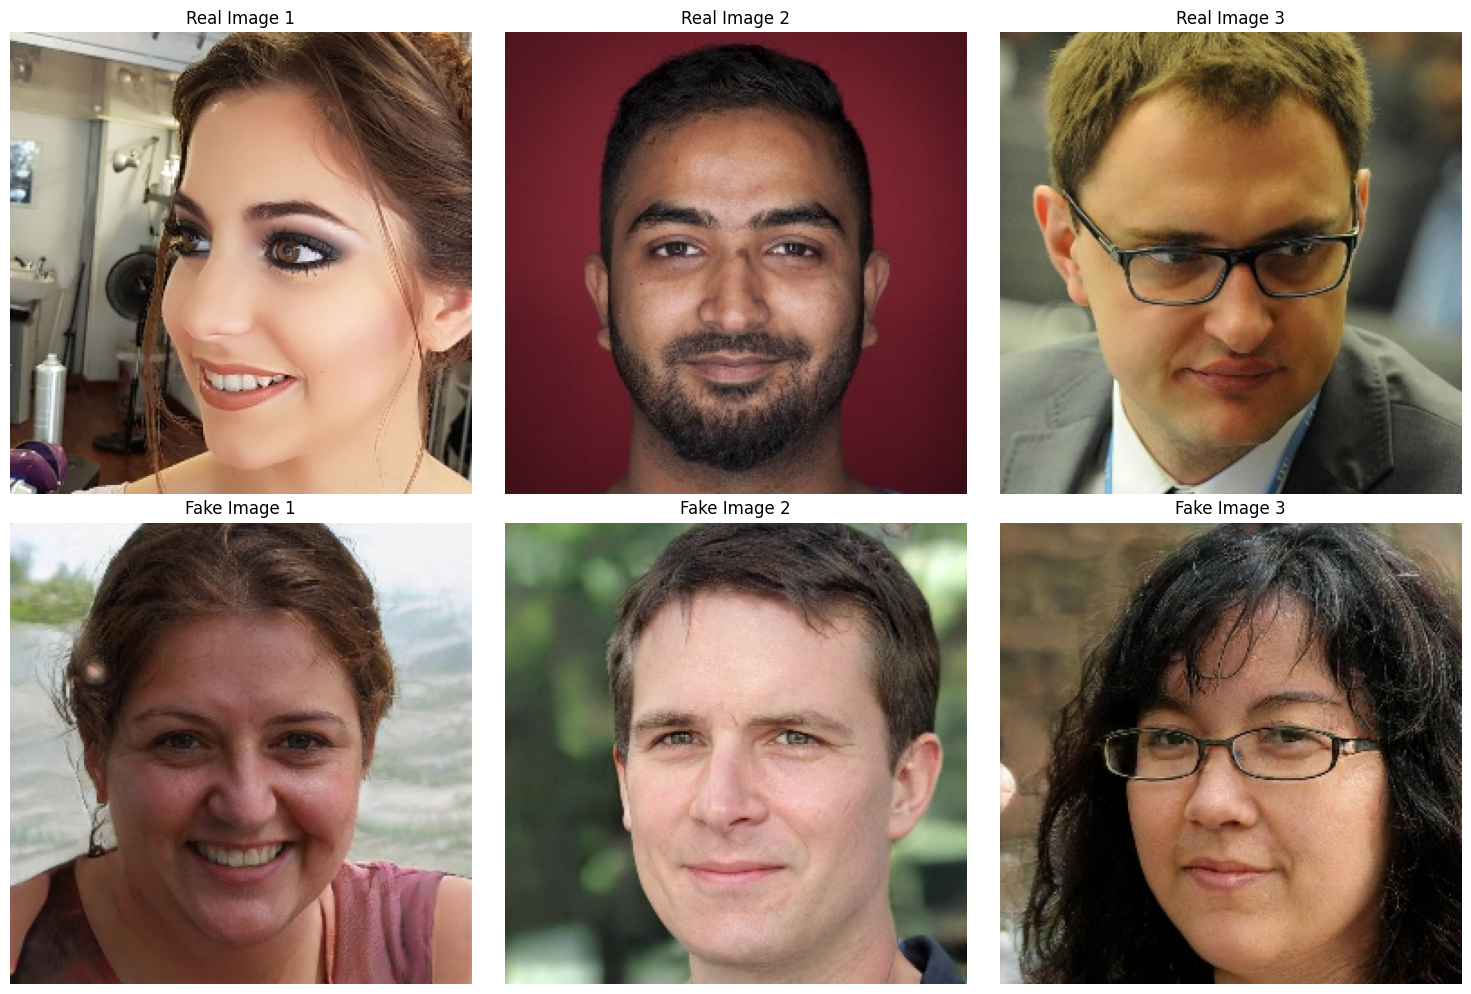

In [10]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [11]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

## Logistic Regression for Binary Classification
Logistic Regression is a simple and effective model for binary classification problems. It calculates the probability that a given input belongs to a specific class ('Fake' or 'Real') using the sigmoid function.

---

## 1. Logistic Regression Formula
The logistic regression model estimates the probability of a class label \( y = 1 \) as:

$$
P(y=1 | x) = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{where } z = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n
$$

Here:

- $x = (x_1, x_2, \dots, x_n)$ are the input features.  
- $w_0$ is the bias term.  
- $w_1, w_2, \dots, w_n$ are the weights (parameters) learned by the model.  
- $\sigma(z)$ is the sigmoid function that outputs a value between 0 and 1.




The predicted class is determined by applying a threshold (e.g., 0.5):

$$
\hat{y} =
\begin{cases}
1, & \text{if } P(y=1 | x) \geq 0.5 \\
0, & \text{if } P(y=1 | x) < 0.5
\end{cases}
$$


---

## 2. Performance Metrics
The quality of the model is evaluated using the following metrics:

- **Precision**: The proportion of predicted positive cases that are actually positive.  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensitivity)**: The proportion of actual positive cases that are correctly predicted.  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1-Score**: The harmonic mean of precision and recall.  
  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Accuracy**: The overall percentage of correctly classified instances.  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$


---

### Where:
- \( TP \): True Positives  
- \( TN \): True Negatives  
- \( FP \): False Positives  
- \( FN \): False Negatives  

---

## 3. Steps
1. Images are preprocessed using transformations (resize, grayscale, and tensor conversion).  
2. Images are flattened into 1D arrays to serve as input features for the logistic regression model.  
3. The model is trained on the training dataset to learn the relationship between input features and labels.  
4. Predictions are made on the test dataset, and performance is evaluated using metrics such as accuracy and a detailed classification report.


In [12]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Initialize datasets using the FaceDataset class
train_dataset = FaceDataset(train_df, transform=transform)
test_dataset = FaceDataset(test_df, transform=transform)

# Convert dataset images and labels to NumPy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        img = img.numpy().flatten()  # Flatten the image tensor to a 1D array
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train_lr, y_train_lr = dataset_to_numpy(train_dataset)
X_test_lr, y_test_lr = dataset_to_numpy(test_dataset)

# Preprocess data using StandardScaler (Feature Scaling)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_lr, y_train_lr)

# Make predictions and evaluate the model
y_pred_lr = model.predict(X_test_lr)
accuracy = accuracy_score(y_test_lr, y_pred_lr)

# Generate a detailed classification report
report = classification_report(y_test_lr, y_pred_lr, target_names=["Fake", "Real"])

# Print evaluation results
print("Logistic Regression Model Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Logistic Regression Model Accuracy: 0.7588

Classification Report:
               precision    recall  f1-score   support

        Fake       0.76      0.76      0.76     10000
        Real       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



### Confusion Matrix

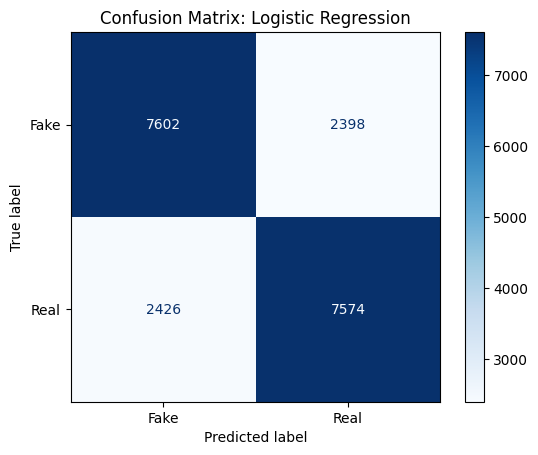

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


### ROC Curve and AUC

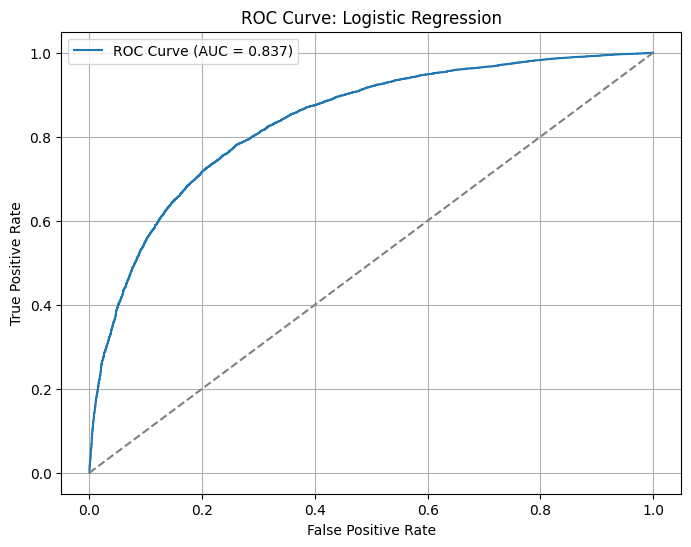

In [14]:
# Calculate ROC curve and AUC
y_prob_lr = model.predict_proba(X_test_lr)[:, 1]  # Predicted probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test_lr, y_prob_lr)
roc_auc = roc_auc_score(y_test_lr, y_prob_lr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend()
plt.grid()
plt.show()


### Precision-Recall Curve

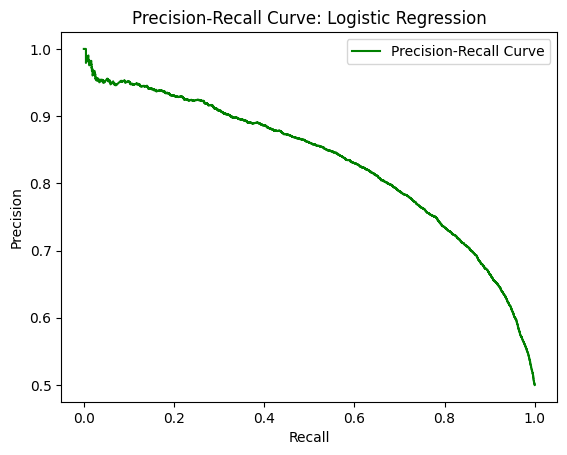

In [15]:
# Generate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_lr, y_prob_lr)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color="green", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Logistic Regression")
plt.legend()
plt.show()


### Logistic Regression: Results and Analysis

---

### 1. Classification Report
- **Fake Images (Class 0):**
  - Precision: **0.76**
  - Recall: **0.76**
  - F1-Score: **0.76**
  - Support: **10,000**

- **Real Images (Class 1):**
  - Precision: **0.76**
  - Recall: **0.76**
  - F1-Score: **0.76**
  - Support: **10,000**

- **Overall Accuracy:** **75.9%**

**Analysis:**  
- The precision, recall, and F1-score values are identical for both classes.  
- This uniformity is due to the balanced dataset, where both classes contribute equally to the model’s evaluation.

---

### 2. Confusion Matrix

- **Fake Images (Class 0):**  
  - Correctly predicted: **7602**  
  - Misclassified as Real: **2398**

- **Real Images (Class 1):**  
  - Correctly predicted: **7574**  
  - Misclassified as Fake: **2426**

**Analysis:**  
- The confusion matrix shows that approximately **24%** of the images are misclassified.  
- Errors are distributed equally across both classes, suggesting no bias in predictions.

---

### 3. ROC Curve and AUC

- **AUC (Area Under the Curve):** **0.837**

**Analysis:**  
- The ROC curve highlights a good separation between the two classes.  
- An AUC of **0.837** indicates that the model performs better than random guessing but is not yet close to an optimal score.

---

### 4. Precision-Recall Curve

- **Average Precision (AP):** **0.76**

**Analysis:**  
- The Precision-Recall curve shows a steady decline in precision as recall increases.  
- While precision is high for lower recall values, the performance degrades as the model attempts to identify more positives.

---

### Overall Conclusions
1. **Model Accuracy:** The logistic regression model achieves an accuracy of **75.9%**, providing a solid baseline performance.  
2. **Misclassifications:** Errors are balanced across both classes, with similar false predictions for Fake and Real images.  
3. **AUC Performance:** An AUC score of **0.837** demonstrates the model's ability to distinguish between the two classes effectively.  
4. **Limitations:** Logistic regression struggles to capture complex relationships in image data due to its linear nature.  



## Convolutional Neural Networks (CNN) for Binary Classification

Convolutional Neural Networks (CNNs) are a type of deep learning model specifically designed to process structured grid data, such as images. CNNs leverage convolutional layers to extract spatial features from images, making them highly effective for tasks like image classification.

---

## 1. CNN Architecture

The Simple CNN used in this project consists of the following components:

1. **Convolutional Layers**: These layers apply filters (kernels) to the input image to detect patterns like edges, shapes, and textures. The output of this operation is called a **feature map**.  
2. **Activation Function (ReLU)**: The Rectified Linear Unit (ReLU) introduces non-linearity into the model.  
3. **Pooling Layers**: Pooling reduces the spatial dimensions of the feature maps, helping to lower computational costs and prevent overfitting.  
4. **Fully Connected Layers**: The flattened output from the convolutional layers is passed through fully connected layers to make the final predictions.  
5. **Output Layer**: Produces a score for each class (Fake or Real) using a softmax function.

The forward pass through the network can be represented as:

$$
x \xrightarrow{\text{Conv + ReLU}} \text{Pooling} \xrightarrow{\text{Conv + ReLU}} \text{Pooling} \xrightarrow{\text{Flatten}} \text{FC Layers} \xrightarrow{\text{Softmax}} \hat{y}
$$

---

### 2. Steps in the CNN Workflow

1. **Input Image Transformation**:  
   - Images are resized to \( 32 x 32 \) pixels for consistency.  
   - Converted to grayscale (1 channel).  
   - Transformed into tensors for PyTorch processing.  

2. **Feature Extraction**:  
   - The convolutional layers apply **3x3 kernels** to learn features such as edges, shapes, and higher-level structures.  
   - **ReLU activations** introduce non-linearity.  
   - **Max-pooling** reduces spatial dimensions while retaining important features.

3. **Classification**:  
   - The extracted features are flattened and passed to fully connected layers to learn relationships between features.  
   - The final layer uses a **softmax activation** to output class probabilities.  

---

## 3. Grad-CAM for Explainability

**Grad-CAM (Gradient-weighted Class Activation Mapping)** provides visual explanations for CNN predictions by highlighting regions of the input image that contributed the most to the classification decision. The steps include:

1. Compute gradients of the target class with respect to the feature maps in the last convolutional layer.  
2. Weight the feature maps using the pooled gradients.  
3. Combine and normalize the weighted feature maps to generate a **heatmap**.  
4. Overlay the heatmap on the original image to visualize important regions.  

---

## 4. Key Advantages of CNNs

1. **Feature Learning**: Unlike logistic regression, CNNs automatically learn relevant features from raw image data.  
2. **Spatial Hierarchies**: Convolution and pooling layers capture spatial relationships, enabling the model to understand local and global patterns.  
3. **Scalability**: CNNs can handle large-scale image datasets with high accuracy.  

---

## 5. Limitations of CNNs

1. **Computational Cost**: Training CNNs requires significant computational resources and time.  
2. **Data Requirement**: CNNs perform best with large labeled datasets.  
3. **Overfitting**: Without proper regularization (e.g., dropout or data augmentation), CNNs may overfit the training data.

---

## 6. Summary of Steps
1. Images are preprocessed (resized, grayscale, and tensor conversion).  
2. The Simple CNN extracts features using convolutional and pooling layers.  
3. Fully connected layers map extracted features to class scores.  
4. Grad-CAM is used to explain CNN predictions.  
5. Performance is evaluated using metrics like accuracy, precision, recall, F1-score, ROC-AUC, and PR curves.


In [16]:
# Define image transformations (same as before)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Define a Simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes ('Fake' and 'Real')

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize datasets and dataloaders
train_dataset = FaceDataset(train_df, transform=transform)
test_dataset = FaceDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)  # Move model to GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))


Epoch [1/10], Loss: 0.5706
Epoch [2/10], Loss: 0.4874
Epoch [3/10], Loss: 0.4349
Epoch [4/10], Loss: 0.3914
Epoch [5/10], Loss: 0.3582
Epoch [6/10], Loss: 0.3279
Epoch [7/10], Loss: 0.3058
Epoch [8/10], Loss: 0.2808
Epoch [9/10], Loss: 0.2626
Epoch [10/10], Loss: 0.2444
Classification Report:
               precision    recall  f1-score   support

        Fake       0.87      0.86      0.86     10000
        Real       0.86      0.87      0.87     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



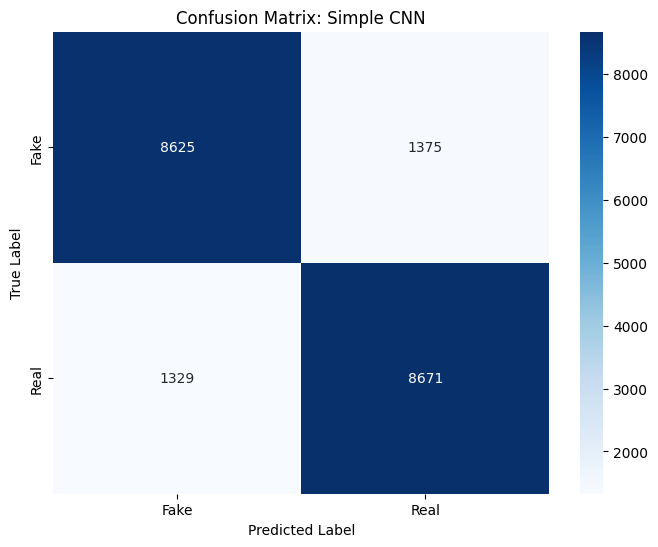

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix: Simple CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<ipython-input-19-9885ce8de6f2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.softmax(model(torch.tensor(img).unsqueeze(0).to(device)), dim=1)


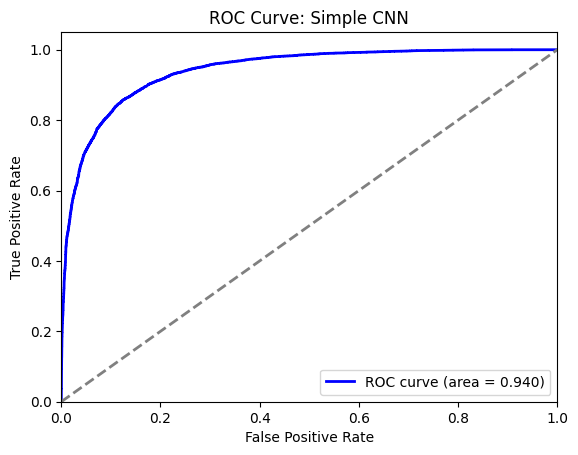

In [19]:
# ROC Curve
y_true_binary = np.array(y_true)  # Ground truth labels
y_pred_probs = np.array([
    torch.softmax(model(torch.tensor(img).unsqueeze(0).to(device)), dim=1)
    .cpu().detach().numpy()[0][1] for img, _ in test_dataset
])

fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Simple CNN")
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


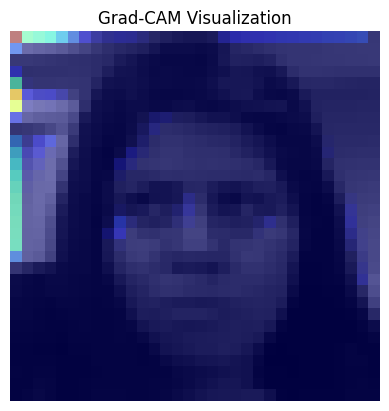

In [21]:
# Grad-CAM
def generate_gradcam(model, image, target_class, device):
    model.eval()  # Set model to evaluation mode

    gradients = None

    def save_gradient(grad):
        nonlocal gradients
        gradients = grad

    # Forward pass and save gradients of the last convolutional layer
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_backward_hook(lambda m, grad_in, grad_out: save_gradient(grad_out[0]))

    image = image.unsqueeze(0).to(device)  # Add batch dimension
    image.requires_grad = True

    output = model(image)
    model.zero_grad()
    class_score = output[0, target_class]  # Score for the target class
    class_score.backward()

    # Get gradients and activations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.conv1(image).detach()  # Get last conv layer activations

    # Weight the activations
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)  # Apply ReLU
    heatmap /= torch.max(heatmap)  # Normalize

    return heatmap.cpu()

# Test Grad-CAM on a single image
sample_image, label = test_dataset[0]
heatmap = generate_gradcam(model, sample_image, target_class=label, device=device)

# Visualize Grad-CAM
plt.imshow(sample_image.squeeze(), cmap="gray")  # Original image
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Grad-CAM heatmap overlay
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()


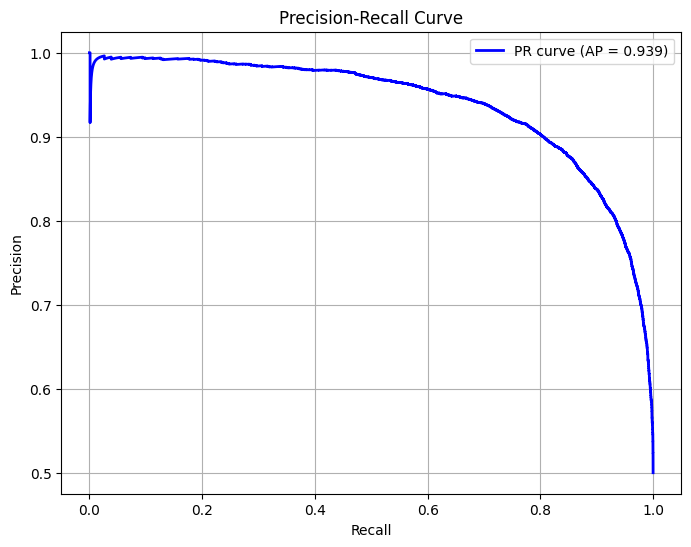

In [22]:
# Get predicted probabilities for the positive class (Real)
model.eval()
y_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = torch.softmax(model(images), dim=1)  # Apply softmax to get probabilities
        y_probs.extend(outputs[:, 1].cpu().numpy())   # Get probabilities for class 1 (Real)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)
average_precision = average_precision_score(y_true, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


## Conclusions for Simple CNN Results

### 1. **Loss Trend**
- The **training loss** consistently decreases from **0.5706** in the first epoch to **0.2444** in the tenth epoch.  
- This demonstrates effective training and convergence of the CNN model.

---

### 2. **Classification Report**
- **Fake Images (Class 0):**  
  - Precision: **0.87**  
  - Recall: **0.86**  
  - F1-Score: **0.86**  

- **Real Images (Class 1):**  
  - Precision: **0.86**  
  - Recall: **0.87**  
  - F1-Score: **0.87**  

**Overall Metrics:**
- **Accuracy:** **86%**  
- **Macro Avg (F1-Score):** **0.86**  
- **Weighted Avg (F1-Score):** **0.86**

**Analysis:**
- The model performs well across both classes, achieving balanced precision and recall.  
- Compared to logistic regression, the Simple CNN shows a significant improvement in accuracy and F1-scores.

---

### 3. **Confusion Matrix**
- **Fake Images (Class 0):**  
  - Correctly predicted: **8625**  
  - Misclassified as Real: **1375**

- **Real Images (Class 1):**  
  - Correctly predicted: **8671**  
  - Misclassified as Fake: **1329**

**Analysis:**  
- The Simple CNN achieves more balanced predictions with fewer misclassifications compared to logistic regression.  
- Both classes show relatively low misclassification rates.

---

### 4. **ROC Curve and AUC**
- The **ROC Curve** illustrates the trade-off between the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**.  
- **AUC (Area Under the Curve):** **0.940**

**Analysis:**
- An AUC of **0.94** indicates excellent performance, as the model effectively separates the two classes.  
- The ROC curve approaches the top-left corner, showing high sensitivity and low false positives.

---

### 5. **Precision-Recall Curve**
- The **Precision-Recall Curve** demonstrates the trade-off between precision and recall.  
- **Average Precision (AP):** **0.939**

**Analysis:**
- The AP score of **0.939** suggests strong performance, especially for imbalanced or challenging datasets.  
- Precision remains consistently high across different recall levels, highlighting the model's reliability in predicting positive cases.

---

### 6. **Grad-CAM Visualization**
- **Grad-CAM** provides insights into which regions of the image contribute most to the model's predictions.  
- The heatmap over the image highlights relevant features, indicating that the Simple CNN successfully focuses on meaningful areas for decision-making.

**Analysis:**
- Grad-CAM demonstrates that the model captures key facial features effectively, validating the interpretability of the CNN.

---

### Overall Conclusions
1. **Model Performance:** The Simple CNN achieves an accuracy of **86%**, with strong precision and recall across both classes.  
2. **AUC and Precision-Recall:** The AUC score of **0.94** and AP score of **0.939** indicate robust performance.  
3. **Visual Interpretability:** Grad-CAM shows that the model makes decisions based on relevant image features.  
4. **Improvements:** Compared to logistic regression, the Simple CNN provides significant gains in accuracy, F1-scores, and interpretability.

---
